<a href="https://colab.research.google.com/github/ChintzRuparel/ECE6143/blob/main/2_advertising_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment: Linear regression on the Advertising data

*Fraida Fund*

Submit answers to the questions in PrairieLearn as you work through this notebook.

To illustrate principles of linear regression, we are going to use some data from the textbook “An Introduction to Statistical Learning withApplications in R” (Gareth James, Daniela Witten, Trevor Hastie, Robert Tibshirani) (available via NYU Library).

The dataset is described as follows:

> Suppose that we are statistical consultants hired by a client to provide advice on how to improve sales of a particular product. The `Advertising` data set consists of the sales of that product in 200 different markets, along with advertising budgets for the product in each of those markets for three different media: TV, radio, and newspaper.
>
> …
>
> It is not possible for our client to directly increase sales of the product. On the other hand, they can control the advertising expenditure in each of the three media. Therefore, if we determine that there is an association between advertising and sales, then we can instruct our client to adjust advertising budgets, thereby indirectly increasing sales. In other words, our goal is to develop an accurate model that can be used to predict sales on the basis of the three media budgets.

Sales are reported in thousands of units, and TV, radio, and newspaper budgets, are reported in thousands of dollars.

For this assignment, you will fit a linear regression model to a small dataset. You will iteratively improve your linear regression model by examining the residuals at each stage, in order to identify problems with the model.

Make sure to include your name and net ID in a text cell at the top of the notebook.

In [ ]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### 0. Read in and pre-process data

In this section, you will read in the “Advertising” data, and make sure it is loaded correctly. Visually inspect the data using a pairplot, and note any meaningful observations. In particular, comment on which features appear to be correlated with product sales, and which features appear to be correlated with one another. Then, split the data into training data (70%) and test data (30%).

**The code in this section is provided for you**.

#### Read in data

In [ ]:
!wget 'https://www.statlearning.com/s/Advertising.csv' -O 'Advertising.csv'

--2024-10-03 00:19:01--  https://www.statlearning.com/s/Advertising.csv
Resolving www.statlearning.com (www.statlearning.com)... 198.185.159.144, 198.49.23.145, 198.185.159.145, ...
Connecting to www.statlearning.com (www.statlearning.com)|198.185.159.144|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://static1.squarespace.com/static/5ff2adbe3fe4fe33db902812/t/5fffe03b4091076ff5b30c72/1610604603901/Advertising.csv [following]
--2024-10-03 00:19:01--  https://static1.squarespace.com/static/5ff2adbe3fe4fe33db902812/t/5fffe03b4091076ff5b30c72/1610604603901/Advertising.csv
Resolving static1.squarespace.com (static1.squarespace.com)... 151.101.0.238, 151.101.64.238, 151.101.128.238, ...
Connecting to static1.squarespace.com (static1.squarespace.com)|151.101.0.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4555 (4.4K) [text/csv]
Saving to: ‘Advertising.csv’

Advertising.csv     100%[===================>]   4.45K  --.-KB/s  

In [ ]:
df  = pd.read_csv('Advertising.csv', index_col=0)
df.head()

,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


Note that in this dataset, the first column in the data file is the row label; that’s why we use `index_col=0` in the `read_csv` command. If we would omit that argument, then we would have an additional (unnamed) column in the dataset, containing the row number.

(You can try removing the `index_col` argument and re-running the cell above, to see the effect and to understand why we used this argument.)

#### Visually inspect the data

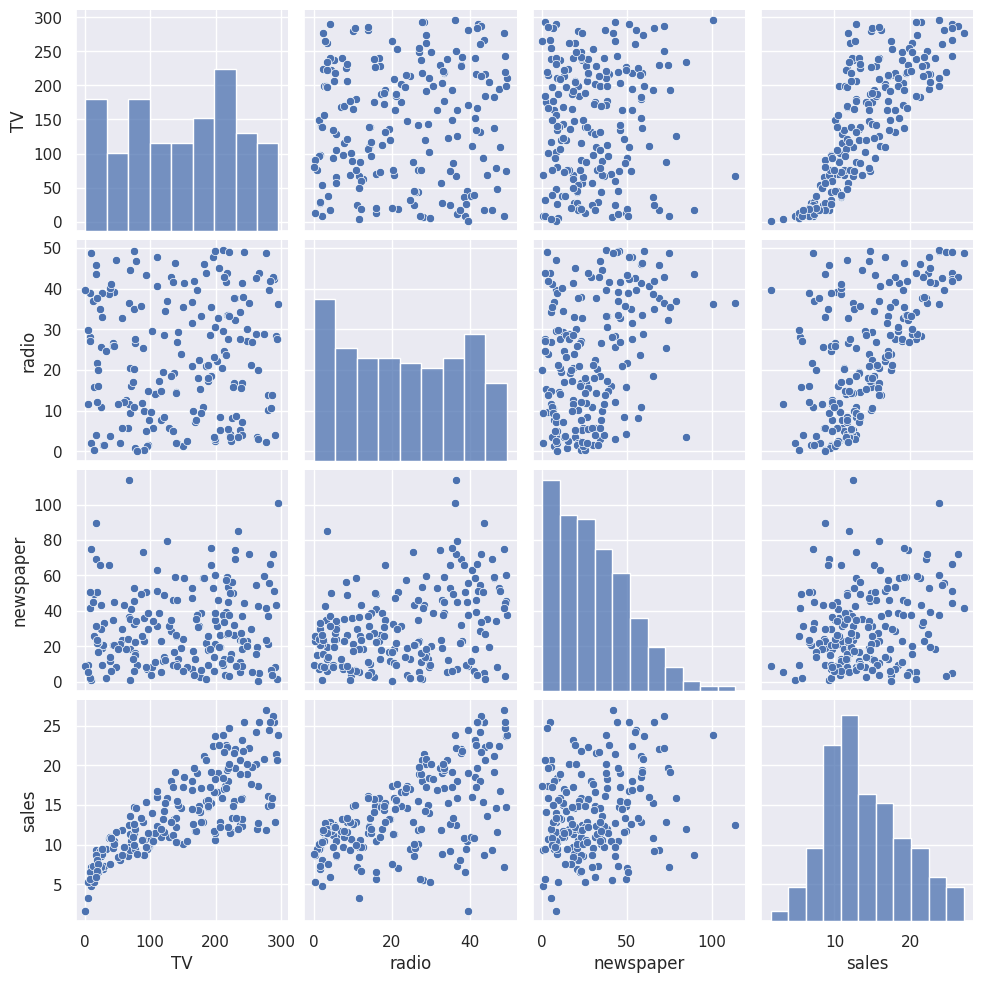

In [ ]:
sns.pairplot(df);

The most important panels here are on the bottom row, where `sales` is on the vertical axis and the advertising budgets are on the horizontal axes.

Looking at this row, it appears that TV ad spending and radio ad spending are likely to be useful predictive features for `sales`; for newspaper ad spending, it is not clear from the pairplot whether there is a relationship.

#Comments on Data

The bottom row shows sales on the vertical axis and each type of advertising on the horizontal axis: Each chart indicates that type of advertising, TV/radio/newspaper may be good at promoting sales.

There is evidence that spots on TV lead to high sales.

Radio ads also seem connected with sales, but it does not seem as "tight".

There might and might not exist a positive association between newspapers ads and sales but it is hard to perceive through eye.

There's no simple visible relationship between the budgets for most advertising types. We can kind of see a correlation between newspaper ad budgets and other, but as we know it's hard to tell visually.

#### Split up data

We will use 70% of the data for training and the remaining 30% to evaluate the regression model on data *not* used for training.

In [ ]:
train, test = train_test_split(df, test_size=0.3, random_state=9)

We will set the `random_state` to a constant so that every time you run this notebook, exactly the same data points will be assigned to test vs. training sets. This is helpful in the debugging stage.

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140 entries, 134 to 127
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         140 non-null    float64
 1   radio      140 non-null    float64
 2   newspaper  140 non-null    float64
 3   sales      140 non-null    float64
dtypes: float64(4)
memory usage: 5.5 KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, 85 to 7
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         60 non-null     float64
 1   radio      60 non-null     float64
 2   newspaper  60 non-null     float64
 3   sales      60 non-null     float64
dtypes: float64(4)
memory usage: 2.3 KB


### 1. Fit simple linear regression models

Use the training data to fit a simple linear regression to predict product sales, for each of three features: TV ad budget, radio ad budget, and newspaper ad budget. In other words, you will fit *three* regression models, with each model being trained on one feature. For each of the three regression models, create a plot of the training data and the regression line, with product sales ($y$) on the vertical axis and the feature on which the model was trained ($x$) on the horizontal axis.

Also, for each regression model, print the intercept and coefficients, and compute the MSE and R2 on the training data, and MSE and R2 on the test data.

Comment on the results. Which type of ad spending seems to be associated with the largest increase in product sales? Which regression model is most effective at predicting product sales?

**The code in this section is provided for you**. However, you will need to add comments, observations, and answers to the questions.

#### Fit a simple linear regression

In [ ]:
reg_tv    = LinearRegression().fit(train[['TV']], train['sales'])
reg_radio = LinearRegression().fit(train[['radio']], train['sales'])
reg_news  = LinearRegression().fit(train[['newspaper']], train['sales'])

#### Look at coefficients

In [ ]:
print("TV       : ", reg_tv.coef_[0], reg_tv.intercept_)
print("Radio    : ", reg_radio.coef_[0], reg_radio.intercept_)
print("Newspaper: ", reg_news.coef_[0], reg_news.intercept_)

TV       :  0.04964468781898984 6.711432632336138
Radio    :  0.21062312839115208 8.997640913704718
Newspaper:  0.046574464282301664 12.375549417451523


#### Plot data and regression line

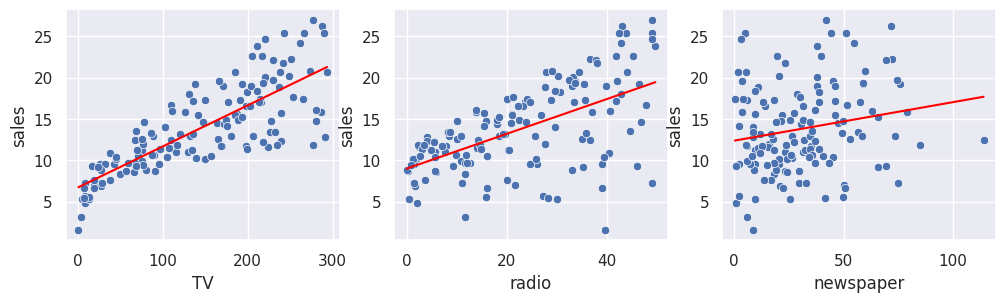

In [ ]:
fig = plt.figure(figsize=(12,3))

plt.subplot(1,3,1)
sns.scatterplot(data=train, x="TV", y="sales");
sns.lineplot(data=train, x="TV", y=reg_tv.predict(train[['TV']]), color='red');

plt.subplot(1,3,2)
sns.scatterplot(data=train, x="radio", y="sales");
sns.lineplot(data=train, x="radio", y=reg_radio.predict(train[['radio']]), color='red');

plt.subplot(1,3,3)
sns.scatterplot(data=train, x="newspaper", y="sales");
sns.lineplot(data=train, x="newspaper", y=reg_news.predict(train[['newspaper']]), color='red');

#### Compute R2, MSE for simple regression

In [ ]:
y_pred_tr_tv    = reg_tv.predict(train[['TV']])
y_pred_tr_radio = reg_radio.predict(train[['radio']])
y_pred_tr_news  = reg_news.predict(train[['newspaper']])

In [ ]:
r2_tr_tv    = metrics.r2_score(train['sales'], y_pred_tr_tv)
r2_tr_radio = metrics.r2_score(train['sales'], y_pred_tr_radio)
r2_tr_news  = metrics.r2_score(train['sales'], y_pred_tr_news)
print("TV       : ", r2_tr_tv)
print("Radio    : ", r2_tr_radio)
print("Newspaper: ", r2_tr_news)

TV       :  0.6462575775839753
Radio    :  0.33630082549935214
Newspaper:  0.0373981756207491


In [ ]:
mse_tr_tv    = metrics.mean_squared_error(train['sales'], y_pred_tr_tv)
mse_tr_radio = metrics.mean_squared_error(train['sales'], y_pred_tr_radio)
mse_tr_news  = metrics.mean_squared_error(train['sales'], y_pred_tr_news)
print("TV       : ", mse_tr_tv)
print("Radio    : ", mse_tr_radio)
print("Newspaper: ", mse_tr_news)

TV       :  9.798510609335318
Radio    :  18.384177273212142
Newspaper:  26.663650133692155


In [ ]:
y_pred_ts_tv    = reg_tv.predict(test[['TV']])
y_pred_ts_radio = reg_radio.predict(test[['radio']])
y_pred_ts_news  = reg_news.predict(test[['newspaper']])

In [ ]:
r2_ts_tv    = metrics.r2_score(test['sales'], y_pred_ts_tv)
r2_ts_radio = metrics.r2_score(test['sales'], y_pred_ts_radio)
r2_ts_news  = metrics.r2_score(test['sales'], y_pred_ts_news)
print("TV       : ", r2_ts_tv)
print("Radio    : ", r2_ts_radio)
print("Newspaper: ", r2_ts_news)

TV       :  0.5138892470208256
Radio    :  0.3072356147167632
Newspaper:  0.06497948830922318


In [ ]:
mse_ts_tv    = metrics.mean_squared_error(test['sales'], y_pred_ts_tv)
mse_ts_radio = metrics.mean_squared_error(test['sales'], y_pred_ts_radio)
mse_ts_news  = metrics.mean_squared_error(test['sales'], y_pred_ts_news)
print("TV       : ", mse_ts_tv)
print("Radio    : ", mse_ts_radio)
print("Newspaper: ", mse_ts_news)

TV       :  12.288041294264643
Radio    :  17.511888641395615
Newspaper:  23.635705625160178


#Comments on Simple Linear Regression results

Product sales are most affected by radio ads, as the radio coefficient is the largest. (And we will see in future cases studies that all features share the same scale of thousands of dollars, so they are comparable).

Yet the TV regression model is also capturing sales best — the R2 for the TV regression is

### 2. Explore the residuals for the single linear regression models

We know that computing MSE or R2 is not sufficient to diagnose a problem with a linear regression.

Create some additional plots as described below to help you identify any problems with the regression. Use training data for all of the items below.

For each of the three regression models, you will compute the residuals ($y - \hat{y}$). Then, you’ll create three plots - each with three subplots, one for each regression model - as follows:

**Plot 1**: Create a scatter plot of predicted sales ($\hat{y}$) on the vertical axis, and actual sales ($y$) on the horizontal axis. Make sure both axes use the same scale (the range of the vertical axis should be the same as the range of the horizontal axis) *and* that all three subplots use the same scale. Label each axes, and each plot. What would you expect this plot to look like for a model that explains the data well?

**Plot 2**: Create a scatter plot with the residuals ($y - \hat{y}$) on the vertical axis, and actual sales ($y$) on the horizontal axis. Use the same vertical scale for all three subplots, and the same horizontal scale for all three subplots (but the vertical scale and the horizontal scale will not be the same as one another!). Comment on your observations. Is there a pattern in the residuals (and if so, what might it indicate), or do they appear to have no pattern with respect to actual sales?

**Plot 3**: For each of the three regression models AND each of the three features, create a scatter plot with the residuals ($y - \hat{y}$) on the vertical axis, and the feature ($x$) on the horizontal axis. This plot will include nine subplots in total, for every combination of regression model and feature. Use the same vertical scale for all subplots (but the horizontal scale will depend on the feature!) Make sure to clearly label each axis, and also label each subplot with a title that indicates which regression model it uses. Is there a pattern in the residuals (and if so, what might it indicate), or do they appear to have no pattern with respect to each of the three features?

**The code in this section is not provided for you**. You will need to write code, as well as comments, observations, and answers to the questions.

------------------------------------------------------------------------

Note that in general, to earn full credit, plots must:

-   Be readable (especially text size).
-   Have a label on each axis.
-   Have an appropriate range for each axis. When there are multiple subplots, if the goal is to compare similar things in different subplots, in most cases it is appropriate for them all to use the same range.
-   If there are multiple subplots, or multiple data series in the same plot, it must be made clear which is which.

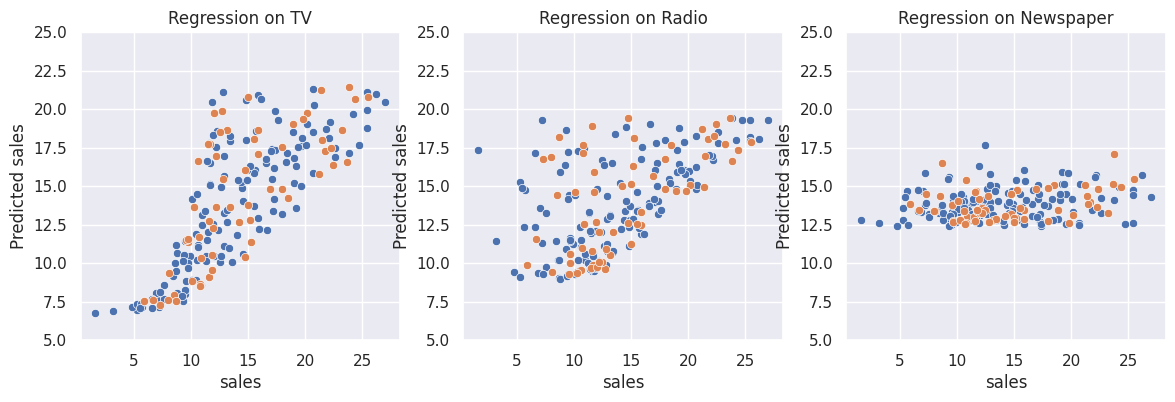

In [ ]:
fig = plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
sns.scatterplot(data=train, x="sales", y=reg_tv.predict(train[['TV']]));
sns.scatterplot(data=test, x="sales", y=reg_tv.predict(test[['TV']]));

plt.ylabel('Predicted sales');
plt.ylim(5,25);
plt.title("Regression on TV");

plt.subplot(1,3,2)
sns.scatterplot(data=train, x="sales", y=reg_radio.predict(train[['radio']]));
sns.scatterplot(data=test, x="sales", y=reg_radio.predict(test[['radio']]));
plt.ylabel('Predicted sales');
plt.ylim(5,25);
plt.title("Regression on Radio");

plt.subplot(1,3,3)
sns.scatterplot(data=train, x="sales", y=reg_news.predict(train[['newspaper']]));
sns.scatterplot(data=test, x="sales", y=reg_news.predict(test[['newspaper']]));
plt.ylabel('Predicted sales');
plt.ylim(5,25);
plt.title("Regression on Newspaper");


In [ ]:
residual_tv_train = train['sales'] - reg_tv.predict(train[['TV']])
residual_news_train = train['sales'] -  reg_news.predict(train[['newspaper']])
residual_radio_train = train['sales'] -  reg_radio.predict(train[['radio']])


In [ ]:
residual_tv_test = test['sales'] - reg_tv.predict(test[['TV']])
residual_news_test = test['sales'] -  reg_news.predict(test[['newspaper']])
residual_radio_test = test['sales'] -  reg_radio.predict(test[['radio']])


In [ ]:
print("Mean residual for TV regression, training data:        ", np.mean(residual_tv_train))
print("Mean residual for radio regression, training data:     ", np.mean(residual_radio_train))
print("Mean residual for newspaper regression, training data: ", np.mean(residual_news_train))

Mean residual for TV regression, training data:         -9.89684524808711e-16
Mean residual for radio regression, training data:      -1.4718385240744933e-15
Mean residual for newspaper regression, training data:  -2.5376526277146436e-15


In [ ]:
print("Mean residual for TV regression, test data:        ", np.mean(residual_tv_test))
print("Mean residual for radio regression, test data:     ", np.mean(residual_news_test))
print("Mean residual for newspaper regression, test data: ", np.mean(residual_radio_test))

Mean residual for TV regression, test data:         0.037294530133494895
Mean residual for radio regression, test data:      0.7463813362234439
Mean residual for newspaper regression, test data:  0.41640875801173804


#Plot of Residuals on actual sales

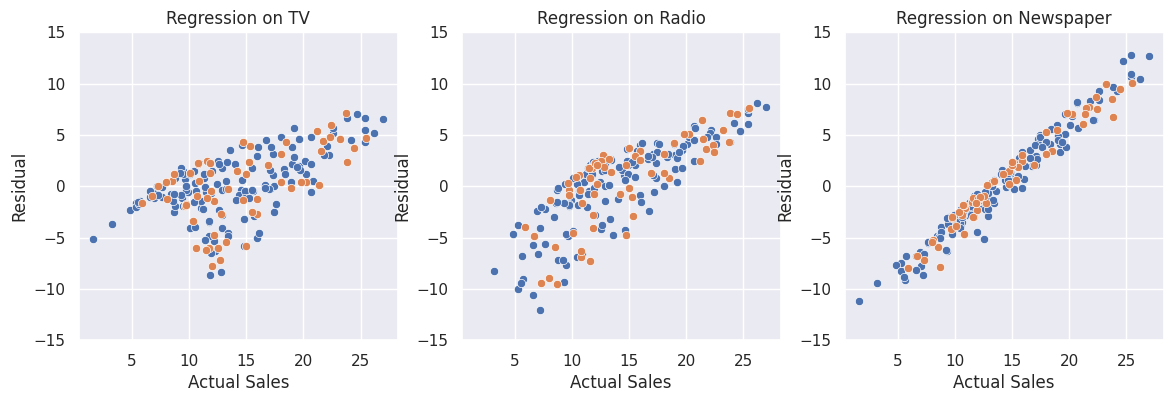

In [ ]:
fig = plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
sns.scatterplot(x=train['sales'], y=residual_tv_train);
sns.scatterplot(x=test['sales'], y=residual_tv_test);
plt.xlabel('Actual Sales')
plt.ylabel('Residual');
plt.ylim(-15, 15)
plt.title("Regression on TV");

plt.subplot(1,3,2)
sns.scatterplot(x=train['sales'], y=residual_radio_train);
sns.scatterplot(x=test['sales'], y=residual_radio_test);
plt.xlabel('Actual Sales')
plt.ylabel('Residual');
plt.ylim(-15, 15)
plt.title("Regression on Radio");

plt.subplot(1,3,3)
sns.scatterplot(x=train['sales'], y=residual_news_train);
sns.scatterplot(x=test['sales'], y=residual_news_test);
plt.xlabel('Actual Sales')
plt.ylabel('Residual');
plt.ylim(-15, 15)
plt.title("Regression on Newspaper");


### Comment on predicted vs. actual sales
Whereas, a residual plot when the model explains all that can be "learned" about target variable should have no pattern to it because error term would entirely random noise (unlearnable). If there is a pattern in the residuals, then this means that model does not learnt everything learnable from the target variable.

There is structure to the residuals (for all three regression models, and for the model on newpaper it is very clearly linear) This hints at something "learnable" not being captured by our model.

#Plot of residual againts Features

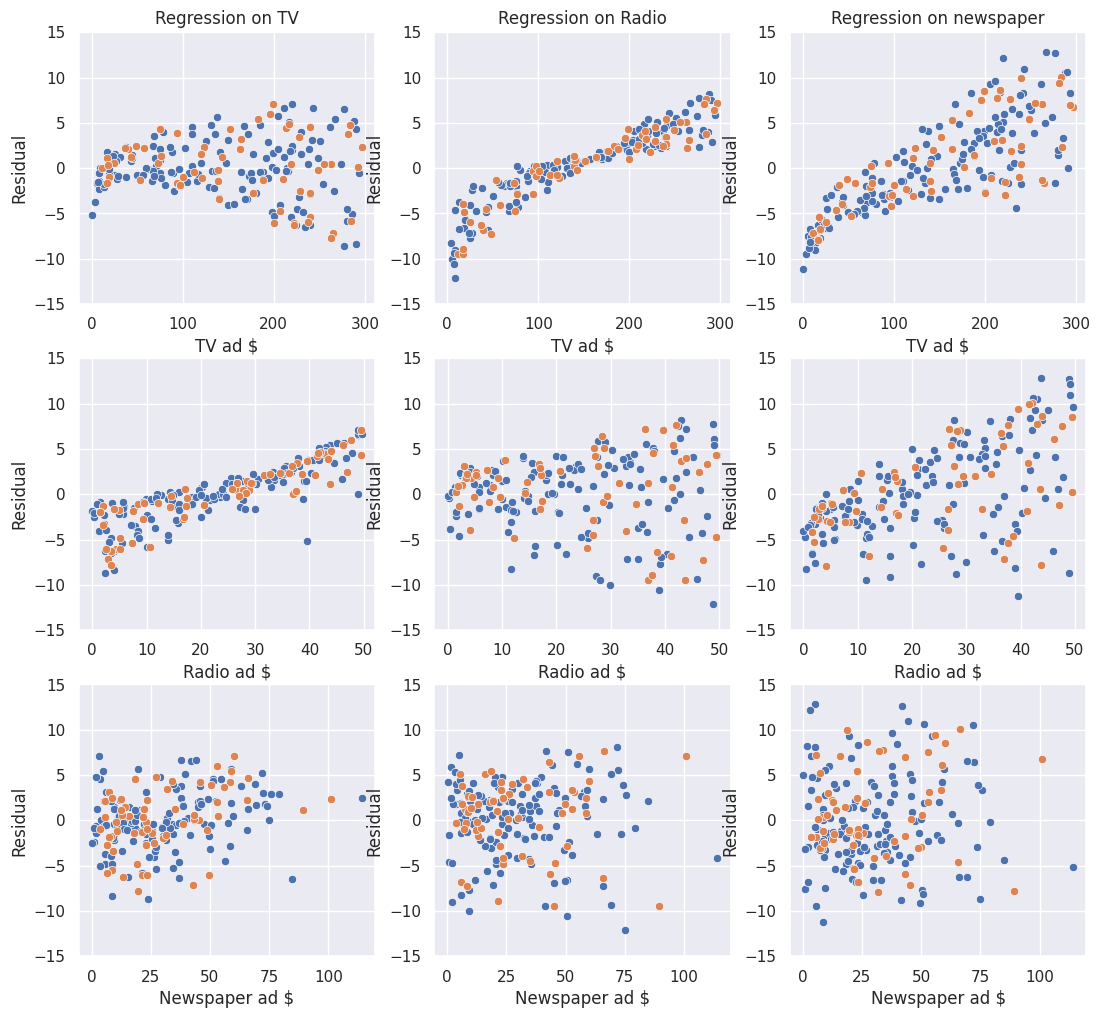

In [ ]:
plt.figure(figsize=(13,12))

plt.subplot(3,3,1)
sns.scatterplot(x=train['TV'], y=residual_tv_train);
sns.scatterplot(x=test['TV'], y=residual_tv_test);
plt.xlabel('TV ad $')
plt.ylabel('Residual');
plt.ylim(-15, 15);
plt.title("Regression on TV");

plt.subplot(3,3,2)
sns.scatterplot(x=train['TV'], y=residual_radio_train);
sns.scatterplot(x=test['TV'], y=residual_radio_test);
plt.xlabel('TV ad $')
plt.ylabel('Residual');
plt.ylim(-15, 15);
plt.title("Regression on Radio");

plt.subplot(3,3,3)
sns.scatterplot(x=train['TV'], y=residual_news_train);
sns.scatterplot(x=test['TV'], y=residual_news_test);
plt.xlabel('TV ad $')
plt.ylabel('Residual');
plt.ylim(-15, 15);
plt.title("Regression on newspaper");

plt.subplot(3,3,4)
sns.scatterplot(x=train['radio'], y=residual_tv_train);
sns.scatterplot(x=test['radio'], y=residual_tv_test);
plt.xlabel('Radio ad $')
plt.ylabel('Residual');
plt.ylim(-15, 15);

plt.subplot(3,3,5)
sns.scatterplot(x=train['radio'], y=residual_radio_train);
sns.scatterplot(x=test['radio'], y=residual_radio_test);
plt.xlabel('Radio ad $')
plt.ylabel('Residual');
plt.ylim(-15, 15);

plt.subplot(3,3,6)
sns.scatterplot(x=train['radio'], y=residual_news_train);
sns.scatterplot(x=test['radio'], y=residual_news_test);
plt.xlabel('Radio ad $')
plt.ylabel('Residual');
plt.ylim(-15, 15);

plt.subplot(3,3,7)
sns.scatterplot(x=train['newspaper'], y=residual_tv_train);
sns.scatterplot(x=test['newspaper'], y=residual_tv_test);
plt.xlabel('Newspaper ad $')
plt.ylabel('Residual');
plt.ylim(-15, 15);

plt.subplot(3,3,8)
sns.scatterplot(x=train['newspaper'], y=residual_radio_train);
sns.scatterplot(x=test['newspaper'], y=residual_radio_test);
plt.xlabel('Newspaper ad $')
plt.ylabel('Residual');
plt.ylim(-15, 15);

plt.subplot(3,3,9)
sns.scatterplot(x=train['newspaper'], y=residual_news_train);
sns.scatterplot(x=test['newspaper'], y=residual_news_test);
plt.xlabel('Newspaper ad $')
plt.ylabel('Residual');
plt.ylim(-15, 15);


#Comments on plot of residuals against features

One could interpret a trend, in the scatter plot of residuals on either side of a feature not used in the modeling as implying that the error is dependent on the value of that feature. This in turn, could be taken to mean that we can improve the model by incorporating that feature in the model.

For example, here we can see that there is some relation of error term in the regression on radio w.r.t TV ad buget. So we can refine the model of regression on radio by adding the TV ad budget as a feature.

We observe the error term is related to regression on TV vs. radio budget and to the error term regression on newspaper vs. TV budget and vs. radio budget.

All of the above suggest that for predicting sales, a model needs both TV and radio budgets. Newspaper budgets seem less predictive.

A non-linear pattern in the plot of residuals against a feature that is included in the model suggests that the error in the model is related to some non-linear function of that feature. (In turn, this should suggest that we could improve the model by including, in the model, a transformation of that feature.)

Here, in the top-left plot, we can clearly see that the residuals of the TV model seem to have some type of nonlinear relationship with the value of this feature - TV.

### 3. Try a multiple linear regression

Next, fit a multiple linear regression to predict product sales, using all three features to train a single model: TV ad budget, radio ad budget, and newspaper ad budget.

Print the intercept and coefficients, and compute the MSE and R2 on the training data, and MSE and R2 on the test data. Comment on the results. Make sure to explain any differences between the coefficients of the multiple regression model, and the coefficients of the three simple linear regression models. If they are different, why?

**The code in the first part of this section is provided for you**. However, you will need to add comments, observations, and answers to the questions.

Also repeat the analysis of part (3) for this regression model. Use training data for all of these items:

**Plot 1**: Create a scatter plot of predicted sales ($\hat{y}$) on the vertical axis, and actual sales ($y$) on the horizontal axis. Make sure both axes use the same scale (the range of the vertical axis should be the same as the range of the horizontal axis). Label each axes. Does this model explain the data more effectively than the simple linear regressions from the previous section?

**Plot 2**: Create a scatter plot with the residuals ($y - \hat{y}$) on the vertical axis, and actual sales ($y$) on the horizontal axis. Comment on your observations. Is there a pattern in the residuals (and if so, what might it indicate), or do they appear to have no pattern with respect to actual sales?

**Plot 3**: For each of the three features, plot the residuals ($y - \hat{y}$) on the vertical axis, and the feature ($x$) on the horizontal axis. Make sure to clearly label each axis. Is there a pattern in the residuals (and if so, what might it indicate), or do they appear to have no pattern with respect to each of the three features?

------------------------------------------------------------------------

Note that in general, to earn full credit, plots must:

-   Be readable (especially text size).
-   Have a label on each axis.
-   Have an appropriate range for each axis. When there are multiple subplots, if the goal is to compare similar things in different subplots, in most cases it is appropriate for them all to use the same range.
-   If there are multiple subplots, or multiple data series in the same plot, it must be made clear which is which.

In [ ]:
reg_multi_ad = LinearRegression().fit(train[['TV', 'radio', 'newspaper']], train['sales'])
print("Coefficients (TV, radio, newspaper):", reg_multi_ad.coef_)
print("Intercept: ", reg_multi_ad.intercept_)

Coefficients (TV, radio, newspaper): [ 0.04636712  0.18249225 -0.00196151]
Intercept:  3.0762941463550604


#### Fit a multiple linear regression

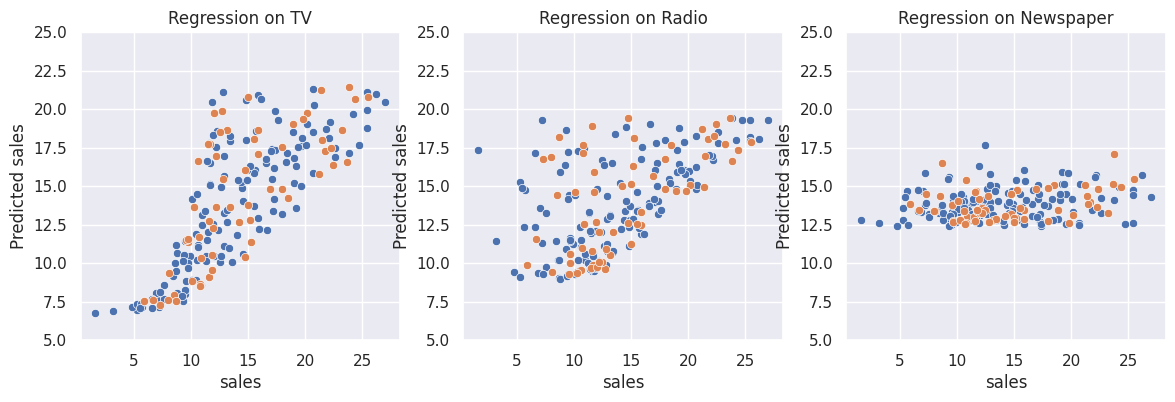

In [ ]:

fig = plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
sns.scatterplot(data=train, x="sales", y=reg_tv.predict(train[['TV']]));
sns.scatterplot(data=test, x="sales", y=reg_tv.predict(test[['TV']]));

plt.ylabel('Predicted sales');
plt.ylim(5,25);
plt.title("Regression on TV");

plt.subplot(1,3,2)
sns.scatterplot(data=train, x="sales", y=reg_radio.predict(train[['radio']]));
sns.scatterplot(data=test, x="sales", y=reg_radio.predict(test[['radio']]));
plt.ylabel('Predicted sales');
plt.ylim(5,25);
plt.title("Regression on Radio");

plt.subplot(1,3,3)
sns.scatterplot(data=train, x="sales", y=reg_news.predict(train[['newspaper']]));
sns.scatterplot(data=test, x="sales", y=reg_news.predict(test[['newspaper']]));
plt.ylabel('Predicted sales');
plt.ylim(5,25);
plt.title("Regression on Newspaper");

In [ ]:
reg_multi = LinearRegression().fit(train[['TV', 'radio', 'newspaper']], train['sales'])

#### Look at coefficients

In [ ]:
print("Coefficients (TV, radio, newspaper):", reg_multi.coef_)
print("Intercept: ", reg_multi.intercept_)

Coefficients (TV, radio, newspaper): [ 0.04636712  0.18249225 -0.00196151]
Intercept:  3.0762941463550604


#### Compute R2, MSE for multiple regression

In [ ]:
y_pred_ts_multi = reg_multi.predict(test[['TV', 'radio', 'newspaper']])

r2_ts_multi  = metrics.r2_score(test['sales'], y_pred_ts_multi)
mse_ts_multi = metrics.mean_squared_error(test['sales'], y_pred_ts_multi)

print("Multiple regression R2:  ", r2_ts_multi)
print("Multiple regression MSE: ", mse_ts_multi)


Multiple regression R2:   0.9034495005656622
Multiple regression MSE:  2.4406300760885373


In [ ]:
y_pred_tr_multi = reg_multi.predict(train[['TV', 'radio', 'newspaper']])

r2_tr_multi  = metrics.r2_score(train['sales'], y_pred_tr_multi)
mse_tr_multi = metrics.mean_squared_error(train['sales'], y_pred_tr_multi)

print("Multiple regression R2:  ", r2_tr_multi)
print("Multiple regression MSE: ", mse_tr_multi)


Multiple regression R2:   0.8934006397815405
Multiple regression MSE:  2.952755722412376


#plot of predicted vs actual sales

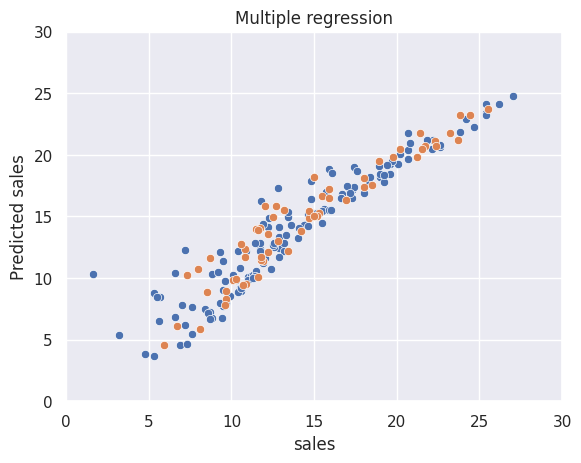

In [ ]:
sns.scatterplot(data=train, x="sales", y=reg_multi_ad.predict(train[['TV', 'radio', 'newspaper']]));
sns.scatterplot(data=test, x="sales", y=reg_multi_ad.predict(test[['TV', 'radio', 'newspaper']]));

plt.ylabel('Predicted sales');
plt.ylim(0,30);
plt.xlim(0,30);
plt.title("Multiple regression");


#Compute Residuals

In [ ]:
residual_multi_train = train['sales'] - reg_multi_ad.predict(train[['TV', 'radio', 'newspaper']])
residual_multi_test = test['sales'] - reg_multi_ad.predict(test[['TV', 'radio', 'newspaper']])


#mean residuals

In [ ]:
print("Mean of residuals for training data: ", np.mean(residual_multi_train))
print("Mean of residuals for test data: ", np.mean(residual_multi_test))

Mean of residuals for training data:  -1.5225915766287861e-16
Mean of residuals for test data:  -0.19099542453178608


#Plot of residuals againts actual sales


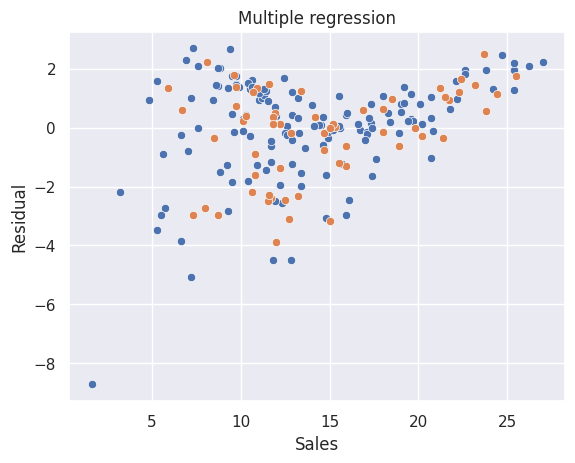

In [ ]:
sns.scatterplot(x=train['sales'], y=residual_multi_train);
sns.scatterplot(x=test['sales'], y=residual_multi_test);

plt.xlabel('Sales')
plt.ylabel('Residual');
plt.title("Multiple regression");


#Comments on plot of residuals against actual sales

A model that captures all of the "learnable" aspects of the target variable should therefore only show random noise in the error term, that is, no obvious pattern in the residual plot. Conversely, pattern in residuals indicates that the model is not capturing all of the "learnable" information about the target variable.

Here, we can see a slight U-shaped pattern in the residuals, which casts doubt that sales is a purely linear function of our three features. We might be able to improve the model by adding some non-linear transformation of features.

#Plot of residuals against features

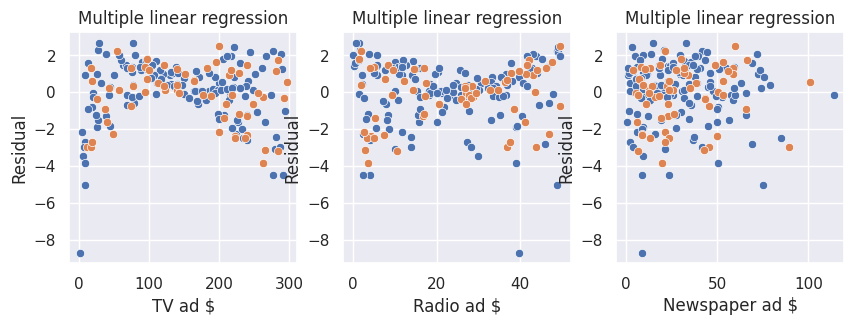

In [ ]:
plt.figure(figsize=(10,3))

plt.subplot(1,3,1)
sns.scatterplot(x=train['TV'], y=residual_multi_train);
sns.scatterplot(x=test['TV'], y=residual_multi_test);

plt.xlabel('TV ad $')
plt.ylabel('Residual');
plt.title("Multiple linear regression");

plt.subplot(1,3,2)
sns.scatterplot(x=train['radio'], y=residual_multi_train);
sns.scatterplot(x=test['radio'], y=residual_multi_test);
plt.xlabel('Radio ad $')
plt.ylabel('Residual');
plt.title("Multiple linear regression");

plt.subplot(1,3,3)
sns.scatterplot(x=train['newspaper'], y=residual_multi_train);
sns.scatterplot(x=test['newspaper'], y=residual_multi_test);
plt.xlabel('Newspaper ad $')
plt.ylabel('Residual');
plt.title("Multiple linear regression");


#Comments on plot of residuals against features

The plot of residuals against newspaper ad sales does not show any distinct pattern, from which we can deduce that the error term is not a function of newspaper ad sales. Our model seems to capture all that is "learnable" from newspaper ad budgets.

However, there is a mild U-shaped pattern in the residuals, against the radio and TV ad budget features; that suggests sales can be predicted partly by some nonlinear transformation of those features.

### 4. Linear regression with interaction terms

Our multiple linear regression includes additive effects of all three types of advertising media. However, it does not include *interaction* effects, in which combining different types of advertising media together results in a bigger boost in sales than just the additive effect of the individual media.

The pattern in the residuals plots from parts (1) through (3) suggest that a model including an interaction effect may explain sales data better than a model including additive effects. Add four columns to each data frame (`train` and `test`):

-   `newspaper` $\times$ `radio` (name this column `newspaper_radio`)
-   `TV` $\times$ `radio` (name this column `TV_radio`)
-   `newspaper` $\times$ `TV` (name this column `newspaper_TV`)
-   `newspaper` $\times$ `radio` $\times$ `TV` (name this column `newspaper_radio_TV`)

Note: you can use the `assign` function in `pandas` ([documentation here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.assign.html)) to create a new column and assign a value to it using operations on other columns.

Then, train a linear regression model on all seven features: the three types of ad budgets, and the four interaction effects. Repeat the analysis of part (3) for the model including interaction effects. Are the interaction effects helpful for explaining the effect of ads on product sales? Are there any patterns evident in the residual plots that suggest further opportunities for improving the model?

**The code in this section is not provided for you**. You will need to write code, in addition to comments, observations, and answers to the questions.

------------------------------------------------------------------------

Note that in general, to earn full credit, plots must:

-   Be readable (especially text size).
-   Have a label on each axis.
-   Have an appropriate range for each axis. When there are multiple subplots, if the goal is to compare similar things in different subplots, in most cases it is appropriate for them all to use the same range.
-   If there are multiple subplots, or multiple data series in the same plot, it must be made clear which is which.

In [ ]:
train = train.copy()
train['TV_radio_interaction'] = train['TV']*train['radio']
train['TV_newspaper_interaction'] = train['TV']*train['newspaper']
train['newspaper_radio_interaction'] = train['newspaper']*train['radio']
train['all_interaction'] = train['newspaper']*train['radio']*train['TV']


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140 entries, 134 to 127
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   TV                           140 non-null    float64
 1   radio                        140 non-null    float64
 2   newspaper                    140 non-null    float64
 3   sales                        140 non-null    float64
 4   TV_radio_interaction         140 non-null    float64
 5   TV_newspaper_interaction     140 non-null    float64
 6   newspaper_radio_interaction  140 non-null    float64
 7   all_interaction              140 non-null    float64
dtypes: float64(8)
memory usage: 9.8 KB


In [ ]:
test = test.copy()
test['TV_radio_interaction'] = test['TV']*test['radio']
test['TV_newspaper_interaction'] = test['TV']*test['newspaper']
test['newspaper_radio_interaction'] = test['newspaper']*test['radio']
test['all_interaction'] = test['newspaper']*test['radio']*test['TV']

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, 85 to 7
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   TV                           60 non-null     float64
 1   radio                        60 non-null     float64
 2   newspaper                    60 non-null     float64
 3   sales                        60 non-null     float64
 4   TV_radio_interaction         60 non-null     float64
 5   TV_newspaper_interaction     60 non-null     float64
 6   newspaper_radio_interaction  60 non-null     float64
 7   all_interaction              60 non-null     float64
dtypes: float64(8)
memory usage: 4.2 KB


In [ ]:
features = ['TV', 'radio', 'newspaper',
     'TV_radio_interaction', 'TV_newspaper_interaction',
     'newspaper_radio_interaction', 'all_interaction']
reg_inter = LinearRegression().fit(train[features], train['sales'])


#Intercepts and Coefficients

In [ ]:
pd.DataFrame({'features': features, 'coefficients':reg_inter.coef_ })

,features,coefficients
0,TV,2.075813e-02
1,radio,1.195198e-02
2,newspaper,2.037552e-02
3,TV_radio_interaction,1.188600e-03
4,TV_newspaper_interaction,-8.067439e-05
5,newspaper_radio_interaction,-2.463848e-05
6,all_interaction,-7.256262e-07


#MSE and R2

In [ ]:
y_pred_inter = reg_inter.predict(test[features])
r2_inter = 1-np.mean( (y_pred_inter - test['sales'])**2 /
    np.std(test['sales'])**2 )
mse_inter = np.mean( (y_pred_inter - test['sales'])**2)


In [ ]:
print("Multiple regression with interaction, test R2:  ", r2_inter)
print("Multiple regression with interaction, test MSE: ", mse_inter)

Multiple regression with interaction, test R2:   0.9782903463061428
Multiple regression with interaction, test MSE:  0.5487825962280907


In [ ]:
y_pred_inter_train = reg_inter.predict(train[features])
r2_inter_train = 1-np.mean( (y_pred_inter_train - train['sales'])**2 /
    np.std(train['sales'])**2 )
mse_inter_train = np.mean( (y_pred_inter_train - train['sales'])**2)


In [ ]:
print("Multiple regression with interaction, training R2:  ", r2_inter_train)
print("Multiple regression with interaction, training MSE: ", mse_inter_train)

Multiple regression with interaction, training R2:   0.9639737928022052
Multiple regression with interaction, training MSE:  0.9979102054843437


#Plot od predicted vs actual sales

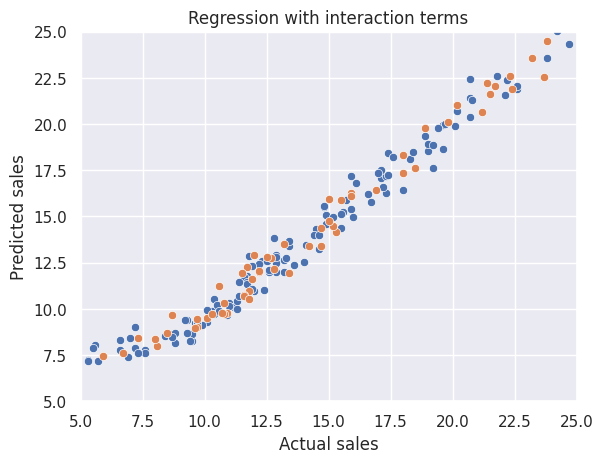

In [ ]:
sns.scatterplot(data=train, x="sales", y=reg_inter.predict(train[features]));
sns.scatterplot(data=test, x="sales", y=reg_inter.predict(test[features]));

plt.ylabel('Predicted sales');
plt.ylim(5,25);
plt.xlabel('Actual sales');
plt.xlim(5,25);

plt.title("Regression with interaction terms");


#Comments on plot of residuals against actual sales

If a model captures everything "learnable" about the target variable, the residual plot should not show any apparent pattern since this error term is due to a random noise which is not "learnable". A residual pattern indicates that the model is not capturing everything "learnable" about the target variable.

Here we can see a pattern in the residuals, showing that for samples with a low level of sales, the model tends to overestimate, the residuals are more strongly negative.

#Compute Residuals

In [ ]:
residual_inter_train = train['sales'] - reg_inter.predict(train[features])
residual_inter_test = test['sales'] - reg_inter.predict(test[features])

In [ ]:
print("Mean of residuals for training data: ", np.mean(residual_inter_train))
print("Mean of residuals for test data: ", np.mean(residual_inter_test))

Mean of residuals for training data:  -1.4845267872130665e-15
Mean of residuals for test data:  0.08311319168719339


#Plot of residuals againts actual sales

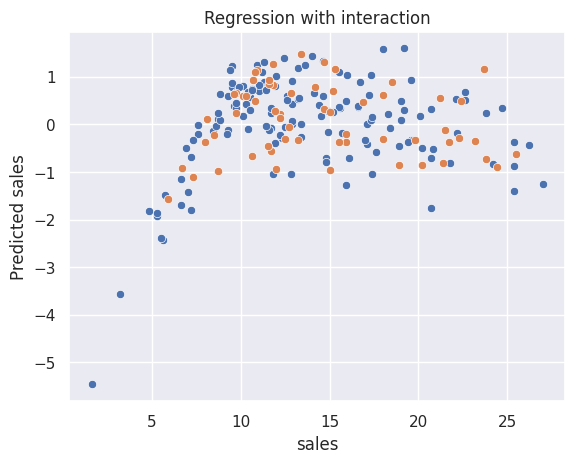

In [ ]:
sns.scatterplot(data=train, x="sales", y=residual_inter_train);
sns.scatterplot(data=test, x="sales", y=residual_inter_test);

plt.ylabel('Predicted sales');
plt.title("Regression with interaction");


#Plot of residuals against features\

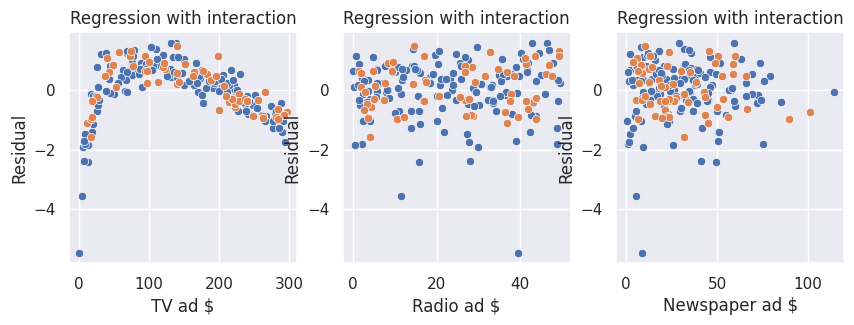

In [ ]:
plt.figure(figsize=(10,3))

plt.subplot(1,3,1)
sns.scatterplot(x=train['TV'], y=residual_inter_train);
sns.scatterplot(x=test['TV'], y=residual_inter_test);
plt.xlabel('TV ad $')
plt.ylabel('Residual');
plt.title("Regression with interaction");

plt.subplot(1,3,2)
sns.scatterplot(x=train['radio'], y=residual_inter_train);
sns.scatterplot(x=test['radio'], y=residual_inter_test);
plt.xlabel('Radio ad $')
plt.ylabel('Residual');
plt.title("Regression with interaction");

plt.subplot(1,3,3)
sns.scatterplot(x=train['newspaper'], y=residual_inter_train);
sns.scatterplot(x=test['newspaper'], y=residual_inter_test);
plt.xlabel('Newspaper ad $')
plt.ylabel('Residual');
plt.title("Regression with interaction");


#Comments on plot of residuals against features

The plots of residuals against newspaper ad sales and radio ad sales do not show too much apparent pattern - meaning that the error term is not a function of newspaper ad sales. Our model seems to capture everything "learnable" from those two features.

On the other hand, we do observe that there is a non-linear pattern in residuals vs. the TV ad budget feature: this suggests that sales can indeed be predicted in part by some kind of non-linear transformation of that feature.